In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering.ranker import generate_ranker_features

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["ranker"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['ranker']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-01 16:43:07.759064: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-01 16:43:07.829806: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-01 16:43:08.275839: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_053
rm: cannot remove '/kaggle/output/exp_053': No such file or directory


In [2]:
oof = pd.read_csv(f'/kaggle/output/{CFG["2nd_stage"]["execution"]["best_exp_id"]}/oof.csv')
oof = oof.rename(columns={"oof": "oof_stage2"})
sub = pd.read_csv(f'/kaggle/output/{CFG["regressor"]["execution"]["best_exp_id"]}/submission.csv')
sub.drop(columns=["oof_stage2"], inplace=True)
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
display(oof.head())
display(sub.head())
display(labels.head())

,series_id,oof_1st,step,oof_stage2,minutes
0,038441c925bb,0.999825,11.0,0.999825,NaN
1,038441c925bb,0.999714,34.0,0.999714,NaN
2,038441c925bb,0.996018,57.0,0.996018,NaN
3,038441c925bb,0.996607,80.0,0.996607,NaN
4,038441c925bb,0.996458,103.0,0.996458,NaN


,step,sub_step_before_modify,key_step,series_id,score,event,oof_regressor,target,minutes
0,4986,5014.0,5025.0,038441c925bb,0.900691,onset,-27.373970,-22.0,1725.0
1,10933,10902.0,10913.0,038441c925bb,0.805931,wakeup,31.558426,30.0,2365.0
2,20288,20378.0,20389.0,038441c925bb,0.607547,onset,-89.549057,-134.0,2945.0
3,23775,23782.0,23793.0,038441c925bb,0.168968,wakeup,-6.925131,0.0,1965.0
4,24058,24035.0,24046.0,038441c925bb,0.241711,onset,23.961412,0.0,3230.0


,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


In [3]:
# 周辺に予測を撒く
dfs = []
for level, diff in enumerate([0, -5, 5, -15, 15, -30, 30]):
    tmp = sub.copy()
    tmp["level"] = level
    tmp["step"] += CFG["feature"]["agg_freq"] * diff
    tmp["key_step"] += CFG["feature"]["agg_freq"] * diff
    tmp["sub_step_before_modify"] += CFG["feature"]["agg_freq"] * diff
    dfs.append(tmp)
sub = pd.concat(dfs, axis=0).reset_index(drop=True)
sub.sort_values(["series_id", "step", "level"], inplace=True)
sub = sub.drop_duplicates(["series_id", "step"], keep="first").reset_index(drop=True)
sub.head()

,step,sub_step_before_modify,key_step,series_id,score,event,oof_regressor,target,minutes,level
0,4296,4324.0,4335.0,038441c925bb,0.900691,onset,-27.37397,-22.0,1725.0,5
1,4641,4669.0,4680.0,038441c925bb,0.900691,onset,-27.37397,-22.0,1725.0,3
2,4871,4899.0,4910.0,038441c925bb,0.900691,onset,-27.37397,-22.0,1725.0,1
3,4986,5014.0,5025.0,038441c925bb,0.900691,onset,-27.37397,-22.0,1725.0,0
4,5101,5129.0,5140.0,038441c925bb,0.900691,onset,-27.37397,-22.0,1725.0,2


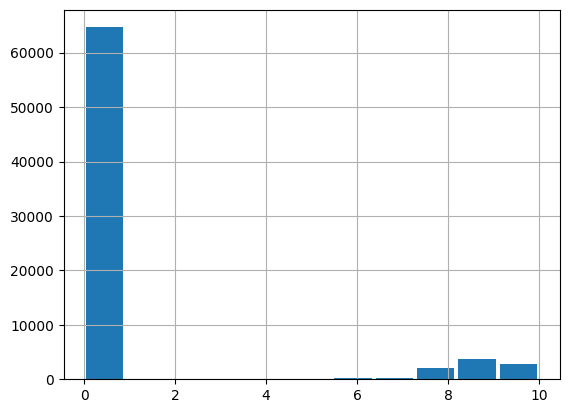

series_id                 5563168
step                      5563168
oof_stage2                5563168
minutes                    906368
target                      73923
sub_step                    73923
key_step                    73923
sub_step_before_modify      73923
event                       73923
level                       73923
score                       73923
oof_regressor               73923
dtype: int64
3.1637360534740946


,series_id,step,oof_stage2,minutes,target,sub_step,key_step,sub_step_before_modify,event,level,score,oof_regressor
0,038441c925bb,11.0,0.999825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,038441c925bb,34.0,0.999714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,038441c925bb,57.0,0.996018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,038441c925bb,80.0,0.996607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,038441c925bb,103.0,0.996458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# 正解ラベルを作成
thresholds = [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    targets = np.zeros(len(sub_df))
    for thresh in thresholds:
        matched = np.zeros(len(sub_df), dtype=bool)
        for step in label_df["step"].values:
            min_dist = thresh
            min_idx = -1            
            for idx, sub_step in enumerate(sub_df["step"].values):
                if matched[idx]:
                    continue
                dist = abs(step - sub_step)
                if dist < min_dist:
                    min_dist = dist
                    min_idx = idx
            if min_idx != -1:
                targets[min_idx] += 1
                matched[min_idx] = True
    sub_df["target"] = targets
    sub_df["sub_step"] = sub_df["step"].values
    dfs.append(sub_df)
sub = pd.concat(dfs).reset_index(drop=True)
plt.hist(sub["target"].values, bins=11, rwidth=0.9)
plt.grid()
plt.show()

train = oof[["series_id", "step", "oof_stage2", "minutes"]].merge(
    sub[["target", "series_id", 
         "sub_step", "key_step", "sub_step_before_modify",
         "event", "level", "score", "oof_regressor"]], 
    left_on=["series_id", "step"], 
    right_on=["series_id", "key_step"], 
    how="left",
    )
print((~train.isna()).sum())
print((train.target ** 2).mean() ** 0.5)
display(train.head())

In [5]:
# スコアの理論値(targetを完璧に当てれた場合)
ideal_sub = sub.copy()
ideal_sub["score"] = ideal_sub["target"]
ideal_sub["step"] = ideal_sub["sub_step"]

labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, ideal_sub)
print(f"score: {score:.4f}")
display(ap_table)

score: 0.8566


event   tolerance
onset   12           0.291171
        36           0.685034
        60           0.890211
        90           0.915466
        120          0.937800
        150          0.946984
        180          0.953663
        240          0.957211
        300          0.959925
        360          0.962847
wakeup  12           0.302253
        36           0.683146
        60           0.899040
        90           0.933041
        120          0.960159
        150          0.964330
        180          0.970171
        240          0.971840
        300          0.972674
        360          0.974969
dtype: float64

In [6]:
# 再現率
thresholds = [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    for thresh in thresholds:
        targets = np.zeros(len(label_df))
        for idx, step in enumerate(label_df["step"].values):           
            min_dist = thresh
            min_idx = -1            
            for sub_step in sub_df["step"].values:    
                dist = abs(step - sub_step)
                if dist < min_dist:
                    min_dist = dist
                    min_idx = idx
            if min_idx != -1:
                targets[idx] = True
        label_df["target"] = targets
        label_df["threshold"] = thresh
        dfs.append(label_df.copy())
recall_df = pd.concat(dfs).reset_index(drop=True)
print(recall_df["target"].mean())
display(recall_df.groupby(["event", "threshold"])["target"].mean())

0.8569848721961398


event   threshold
onset   12           0.291171
        36           0.685243
        60           0.890837
        90           0.916093
        120          0.938635
        150          0.947819
        180          0.954498
        240          0.958046
        300          0.960760
        360          0.963682
wakeup  12           0.302253
        36           0.683146
        60           0.899040
        90           0.933041
        120          0.960367
        150          0.964539
        180          0.970380
        240          0.972048
        300          0.972883
        360          0.975177
Name: target, dtype: float64

In [7]:
# 特徴生成
train, features = generate_ranker_features(train)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

100%|██████████| 277/277 [03:31<00:00,  1.31it/s]


,series_id,step,oof_stage2,minutes,target,sub_step,key_step,sub_step_before_modify,event,level,...,for_pred_rolling_min_50_shift_100_diff,oof_stage2_rolling_median_50_shift_100_diff,oof_stage2_diff_abs_rolling_median_50_shift_100_diff,oof_stage2_mean_rolling_median_50_shift_100_diff,for_pred_rolling_median_50_shift_100_diff,oof_stage2_rolling_square_mean_50_shift_100_diff,oof_stage2_diff_abs_rolling_square_mean_50_shift_100_diff,oof_stage2_mean_rolling_square_mean_50_shift_100_diff,for_pred_rolling_square_mean_50_shift_100_diff,fold
0,038441c925bb,4335.0,0.998871,NaN,0.0,4296.0,4335.0,4324.0,onset,5.0,...,0.0,0.960209,-0.001850,0.960209,0.0,0.997903,-0.000044,0.997903,0.0,2
1,038441c925bb,4680.0,0.998629,NaN,0.0,4641.0,4680.0,4669.0,onset,3.0,...,0.0,0.961013,-0.001600,0.961013,0.0,0.998117,-0.000027,0.998117,0.0,2
2,038441c925bb,4910.0,0.975926,1150.0,0.0,4871.0,4910.0,4899.0,onset,1.0,...,0.0,0.957000,-0.002218,0.957000,0.0,0.996832,-0.000048,0.996832,0.0,2
3,038441c925bb,5025.0,0.116259,1725.0,10.0,4986.0,5025.0,5014.0,onset,0.0,...,0.0,0.953288,-0.002326,0.953288,0.0,0.995514,-0.000049,0.995514,0.0,2
4,038441c925bb,5140.0,0.036174,2300.0,0.0,5101.0,5140.0,5129.0,onset,2.0,...,0.0,0.949933,-0.002923,0.949933,0.0,0.993592,-0.000047,0.993592,0.0,2


(73923, 1390)

In [8]:
# 学習
trn_oof, models = fit_xgb(
    X=train, 
    y=train["target"], 
    folds=train["fold"].astype(int), 
    features=features.all_features(),
    params=CFG["ranker"]["xgboost"], 
    es_rounds=100,
)
train["oof_ranker"] = trn_oof
train["score"] = train["oof_ranker"]
train["key_step"] = train["step"]
train["step"] = train["sub_step"].astype(int)
sub = train[["score", "key_step", "step", "event", "level", "series_id"]]

# 保存
for i, model in enumerate(models):
    model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))
with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:3.02716
[100]	eval-rmse:2.04967
[200]	eval-rmse:1.85637
[300]	eval-rmse:1.82056
[400]	eval-rmse:1.81185
[500]	eval-rmse:1.81015
[600]	eval-rmse:1.80979
[700]	eval-rmse:1.80835
[800]	eval-rmse:1.80753
[900]	eval-rmse:1.80690
[1000]	eval-rmse:1.80673
[1100]	eval-rmse:1.80670
[1159]	eval-rmse:1.80649


 20%|██        | 1/5 [00:21<01:24, 21.10s/it]

== fold 1 ==
[0]	eval-rmse:3.02407
[100]	eval-rmse:2.10500
[200]	eval-rmse:1.91492
[300]	eval-rmse:1.87663
[400]	eval-rmse:1.86625
[500]	eval-rmse:1.86287
[600]	eval-rmse:1.86154
[700]	eval-rmse:1.86081
[800]	eval-rmse:1.85921
[900]	eval-rmse:1.85890
[1000]	eval-rmse:1.85849
[1100]	eval-rmse:1.85846
[1200]	eval-rmse:1.85783
[1300]	eval-rmse:1.85785
[1349]	eval-rmse:1.85787


 40%|████      | 2/5 [00:45<01:08, 22.90s/it]

== fold 2 ==
[0]	eval-rmse:3.01027
[100]	eval-rmse:2.14130
[200]	eval-rmse:1.98515
[300]	eval-rmse:1.95728
[400]	eval-rmse:1.95192
[500]	eval-rmse:1.95005
[600]	eval-rmse:1.94822
[700]	eval-rmse:1.94749
[800]	eval-rmse:1.94720
[900]	eval-rmse:1.94758
[907]	eval-rmse:1.94746


 60%|██████    | 3/5 [01:01<00:39, 19.99s/it]

== fold 3 ==
[0]	eval-rmse:3.02083
[100]	eval-rmse:2.12493
[200]	eval-rmse:1.96419
[300]	eval-rmse:1.93892
[400]	eval-rmse:1.93485
[500]	eval-rmse:1.93450
[568]	eval-rmse:1.93415


 80%|████████  | 4/5 [01:13<00:16, 16.59s/it]

== fold 4 ==
[0]	eval-rmse:2.95830
[100]	eval-rmse:2.10250
[200]	eval-rmse:1.95340
[300]	eval-rmse:1.93114
[400]	eval-rmse:1.92741
[500]	eval-rmse:1.92710
[600]	eval-rmse:1.92593
[700]	eval-rmse:1.92539
[800]	eval-rmse:1.92521
[860]	eval-rmse:1.92551


100%|██████████| 5/5 [01:29<00:00, 17.94s/it]


In [9]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)

score: 0.7291


event   tolerance
onset   12           0.140827
        36           0.536939
        60           0.730545
        90           0.784197
        120          0.814767
        150          0.828775
        180          0.840924
        240          0.852378
        300          0.861588
        360          0.868330
wakeup  12           0.143511
        36           0.527338
        60           0.726540
        90           0.789561
        120          0.820415
        150          0.834787
        180          0.848842
        240          0.864247
        300          0.878629
        360          0.888274
dtype: float64